In [6]:
# Week 1 - Enhanced Data Processing for Crop Disease Detection
# AICTE Cycle 3 (2025) - Sustainable Agriculture Project

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

print("🌱 AICTE Cycle 3 - Sustainable Agriculture: Crop Disease Detection")
print("=" * 60)

# Path to dataset
data_dir = "PlantVillage"

# Check if dataset exists
if not os.path.exists(data_dir):
    print(f"❌ Dataset directory '{data_dir}' not found!")
    print("Please ensure the PlantVillage dataset is in the correct location.")
else:
    print(f"✅ Dataset directory found: {data_dir}")

# List categories (folder names are labels)
categories = os.listdir(data_dir)
print(f"\n📊 Classes found: {len(categories)}")
for i, category in enumerate(categories):
    print(f"{i+1:2d}. {category}")

# Data Processing Parameters
img_size = 128   # resize images to 128x128
max_images_per_class = 500  # Increased from 200 for better training
min_images_per_class = 50   # Minimum images required per class

print(f"\n🔧 Processing Parameters:")
print(f"   - Image Size: {img_size}x{img_size}")
print(f"   - Max Images per Class: {max_images_per_class}")
print(f"   - Min Images per Class: {min_images_per_class}")

# Initialize data containers
X = []
y = []
file_paths = []
class_counts = {}

print(f"\n📂 Loading and Processing Images...")

# Enhanced data loading with validation
for idx, category in enumerate(categories):
    folder = os.path.join(data_dir, category)
    
    if not os.path.isdir(folder):
        print(f"⚠️  Skipping {category} - not a directory")
        continue
    
    image_files = [f for f in os.listdir(folder) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    print(f"Processing {category}: {len(image_files)} images found")
    
    if len(image_files) < min_images_per_class:
        print(f"⚠️  Warning: {category} has only {len(image_files)} images (minimum: {min_images_per_class})")
    
    loaded_count = 0
    failed_count = 0
    
    # Load images with enhanced error handling
    for img in image_files[:max_images_per_class]:  
        img_path = os.path.join(folder, img)
        try:
            # Read image
            img_array = cv2.imread(img_path)
            
            # Validate image
            if img_array is None:
                failed_count += 1
                continue
                
            # Check image dimensions
            if len(img_array.shape) != 3:
                failed_count += 1
                continue
            
            # Convert BGR to RGB (OpenCV uses BGR)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            
            # Resize image
            img_array = cv2.resize(img_array, (img_size, img_size))
            
            # Data validation - check for corrupted images
            if np.any(np.isnan(img_array)) or np.any(np.isinf(img_array)):
                failed_count += 1
                continue
            
            X.append(img_array)
            y.append(idx)
            file_paths.append(img_path)
            loaded_count += 1
            
        except Exception as e:
            failed_count += 1
            continue
    
    class_counts[category] = loaded_count
    print(f"   ✅ Loaded: {loaded_count}, ❌ Failed: {failed_count}")

# Convert to numpy arrays and normalize
print(f"\n🔄 Converting to NumPy arrays and normalizing...")
X = np.array(X, dtype=np.float32) / 255.0   # normalize pixel values (0-1)
y = np.array(y)

print(f"✅ Dataset Shape: {X.shape}, Labels: {y.shape}")
print(f"📊 Total Images Loaded: {len(X):,}")
print(f"🎯 Number of Classes: {len(np.unique(y))}")

# Enhanced Data Analysis
print(f"\n📈 DATASET ANALYSIS")
print("=" * 40)

# Class distribution analysis
class_distribution = pd.DataFrame({
    'Class': categories,
    'Count': [class_counts.get(cat, 0) for cat in categories],
    'Percentage': [class_counts.get(cat, 0) / len(X) * 100 for cat in categories]
})

print("Class Distribution:")
print(class_distribution.to_string(index=False))

# Data quality checks
print(f"\n🔍 DATA QUALITY CHECKS")
print("=" * 40)
print(f"✅ Image Shape Consistency: {X.shape[1:]} for all images")
print(f"✅ Pixel Value Range: [{X.min():.3f}, {X.max():.3f}]")
print(f"✅ No NaN values: {not np.any(np.isnan(X))}")
print(f"✅ No Infinite values: {not np.any(np.isinf(X))}")

# Check for class imbalance
class_counts_array = np.array(list(class_counts.values()))
imbalance_ratio = class_counts_array.max() / class_counts_array.min() if class_counts_array.min() > 0 else float('inf')
print(f"📊 Class Imbalance Ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 3:
    print("⚠️  Significant class imbalance detected - consider data augmentation")
else:
    print("✅ Reasonable class balance")

# Split into training and testing sets with stratification
print(f"\n🔀 TRAIN-TEST SPLIT")
print("=" * 40)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data: {X_train.shape}")
print(f"Testing data: {X_test.shape}")
print(f"Training labels: {y_train.shape}")
print(f"Testing labels: {y_test.shape}")

# Verify stratification
train_class_counts = np.bincount(y_train)
test_class_counts = np.bincount(y_test)

print(f"\nStratification Check:")
for i, category in enumerate(categories):
    if i < len(train_class_counts) and i < len(test_class_counts):
        train_pct = train_class_counts[i] / len(y_train) * 100
        test_pct = test_class_counts[i] / len(y_test) * 100
        print(f"  {category}: Train {train_pct:.1f}%, Test {test_pct:.1f}%")

# Compute class weights for handling imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

print(f"\n⚖️  Class Weights for Balanced Training:")
for i, (category, weight) in enumerate(zip(categories, class_weights)):
    if i < len(class_weights):
        print(f"  {category}: {weight:.3f}")

# Save processed data info
data_info = {
    'total_images': len(X),
    'num_classes': len(categories),
    'image_size': img_size,
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'categories': categories,
    'class_distribution': class_counts,
    'class_weights': class_weight_dict
}

print(f"\n💾 Data processing completed successfully!")
print(f"Ready for model training and validation.")

# 📌 Save processed data for Week 2 training
import pickle

with open("processed_data.pkl", "wb") as f:
    pickle.dump((X_train, X_test, y_train, y_test, categories), f)

print("✅ Processed data saved as 'processed_data.pkl'")


🌱 AICTE Cycle 3 - Sustainable Agriculture: Crop Disease Detection
✅ Dataset directory found: PlantVillage

📊 Classes found: 16
 1. Pepper__bell___Bacterial_spot
 2. Pepper__bell___healthy
 3. PlantVillage
 4. Potato___Early_blight
 5. Potato___healthy
 6. Potato___Late_blight
 7. Tomato_Bacterial_spot
 8. Tomato_Early_blight
 9. Tomato_healthy
10. Tomato_Late_blight
11. Tomato_Leaf_Mold
12. Tomato_Septoria_leaf_spot
13. Tomato_Spider_mites_Two_spotted_spider_mite
14. Tomato__Target_Spot
15. Tomato__Tomato_mosaic_virus
16. Tomato__Tomato_YellowLeaf__Curl_Virus

🔧 Processing Parameters:
   - Image Size: 128x128
   - Max Images per Class: 500
   - Min Images per Class: 50

📂 Loading and Processing Images...
Processing Pepper__bell___Bacterial_spot: 997 images found
Processing Pepper__bell___Bacterial_spot: 997 images found
   ✅ Loaded: 500, ❌ Failed: 0
Processing Pepper__bell___healthy: 1478 images found
   ✅ Loaded: 500, ❌ Failed: 0
Processing Pepper__bell___healthy: 1478 images found
  

📊 GENERATING VISUALIZATIONS


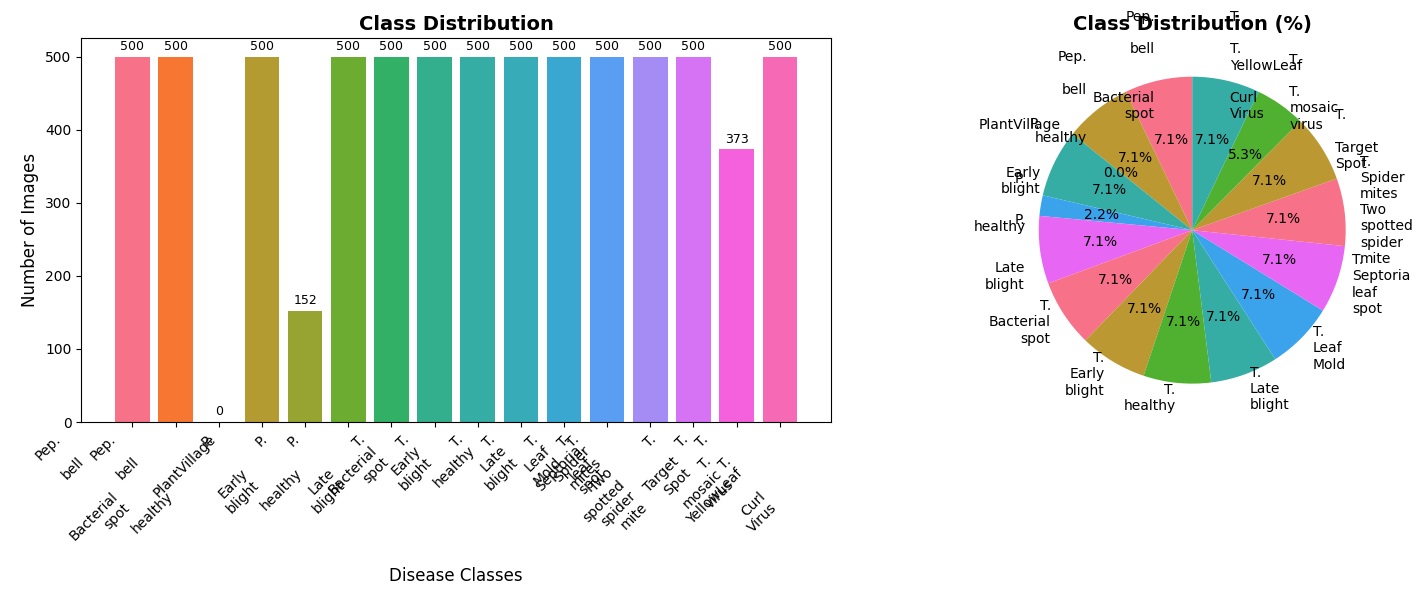


🖼️  Sample Images from Each Class:


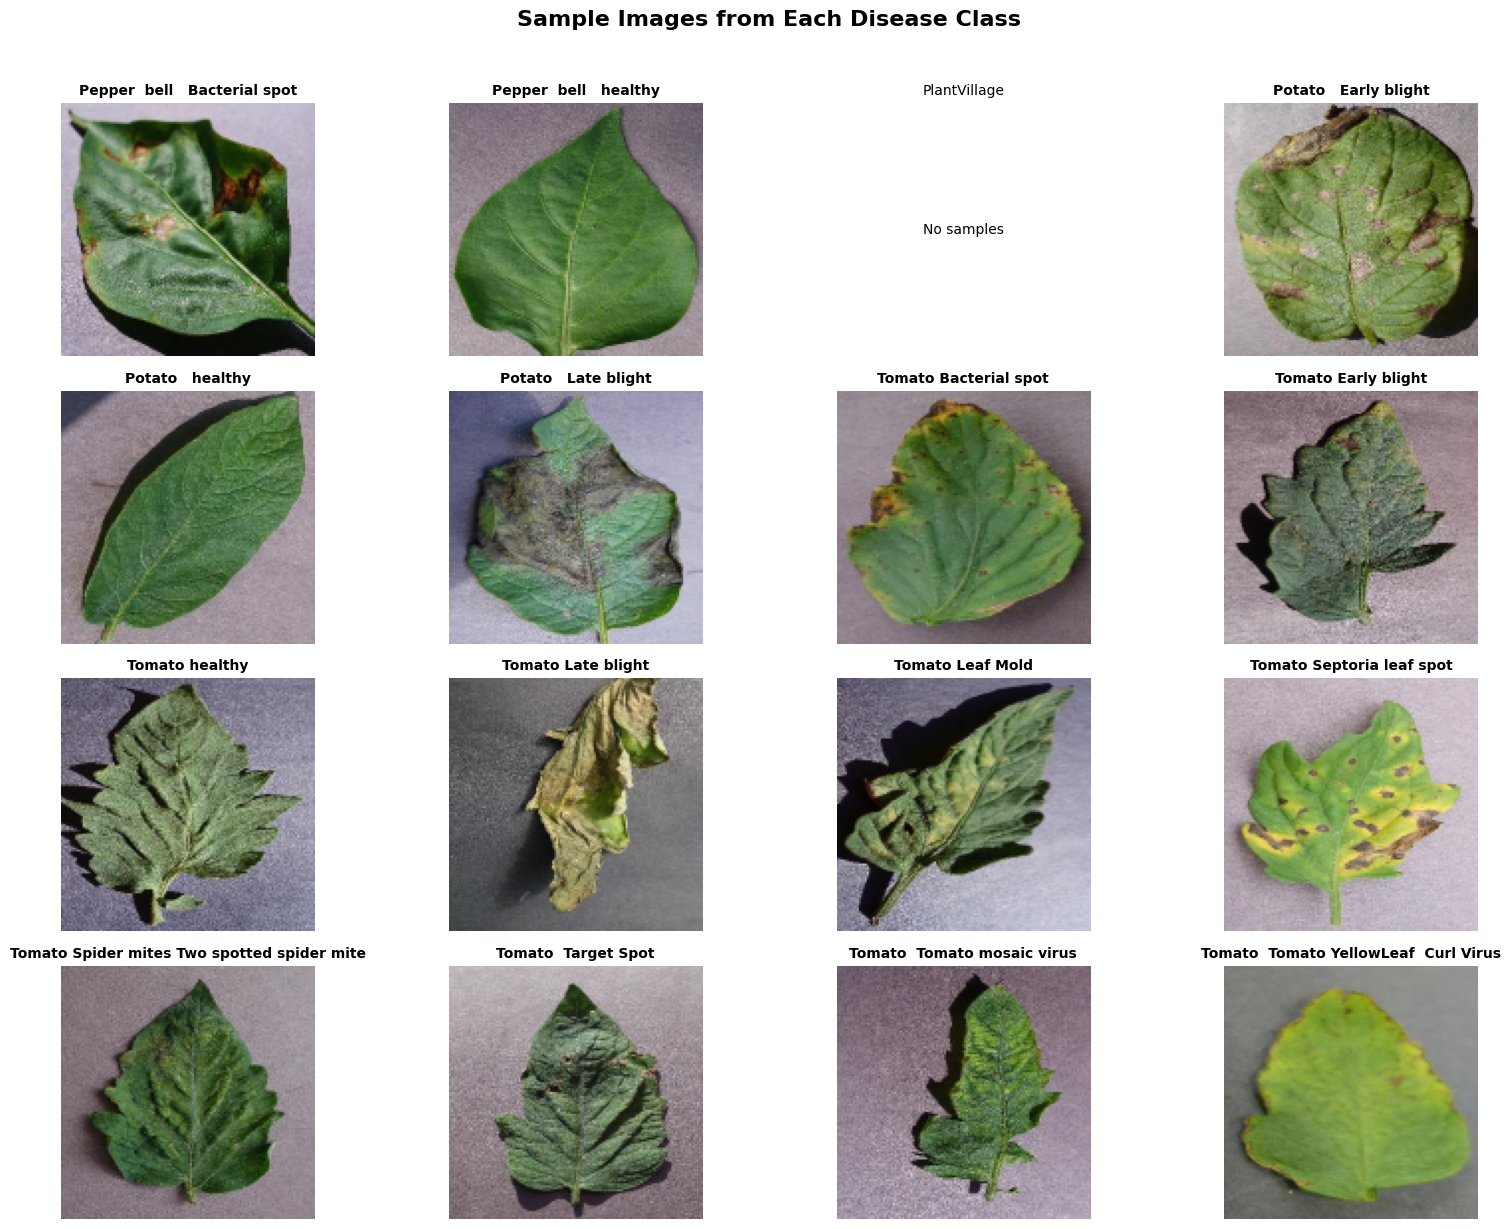


🎲 Random Sample Grid (3x3):


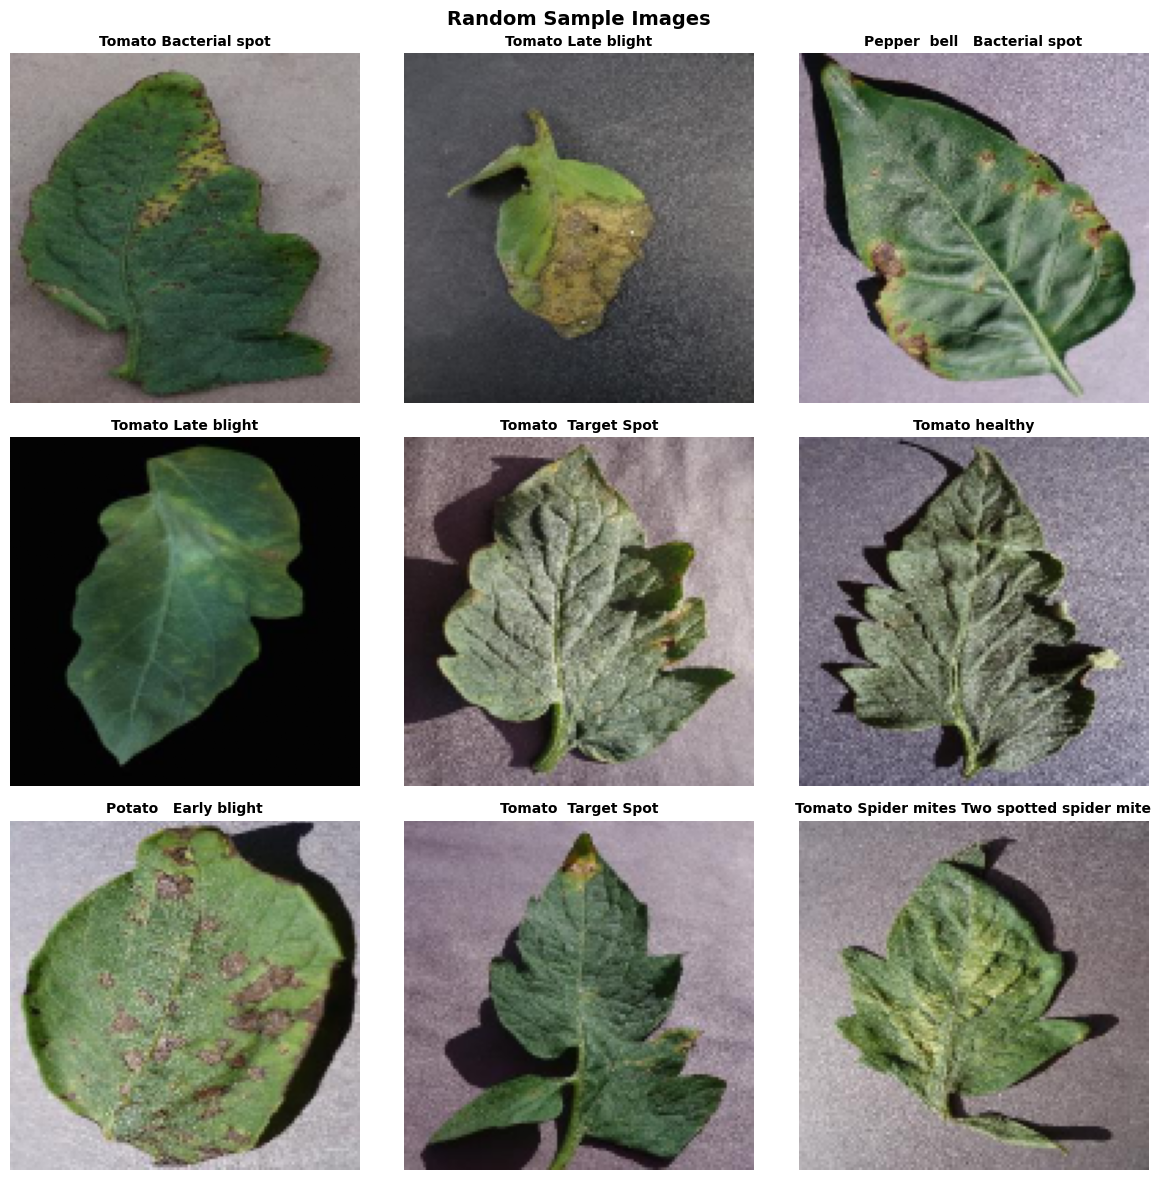


📈 Dataset Statistics:


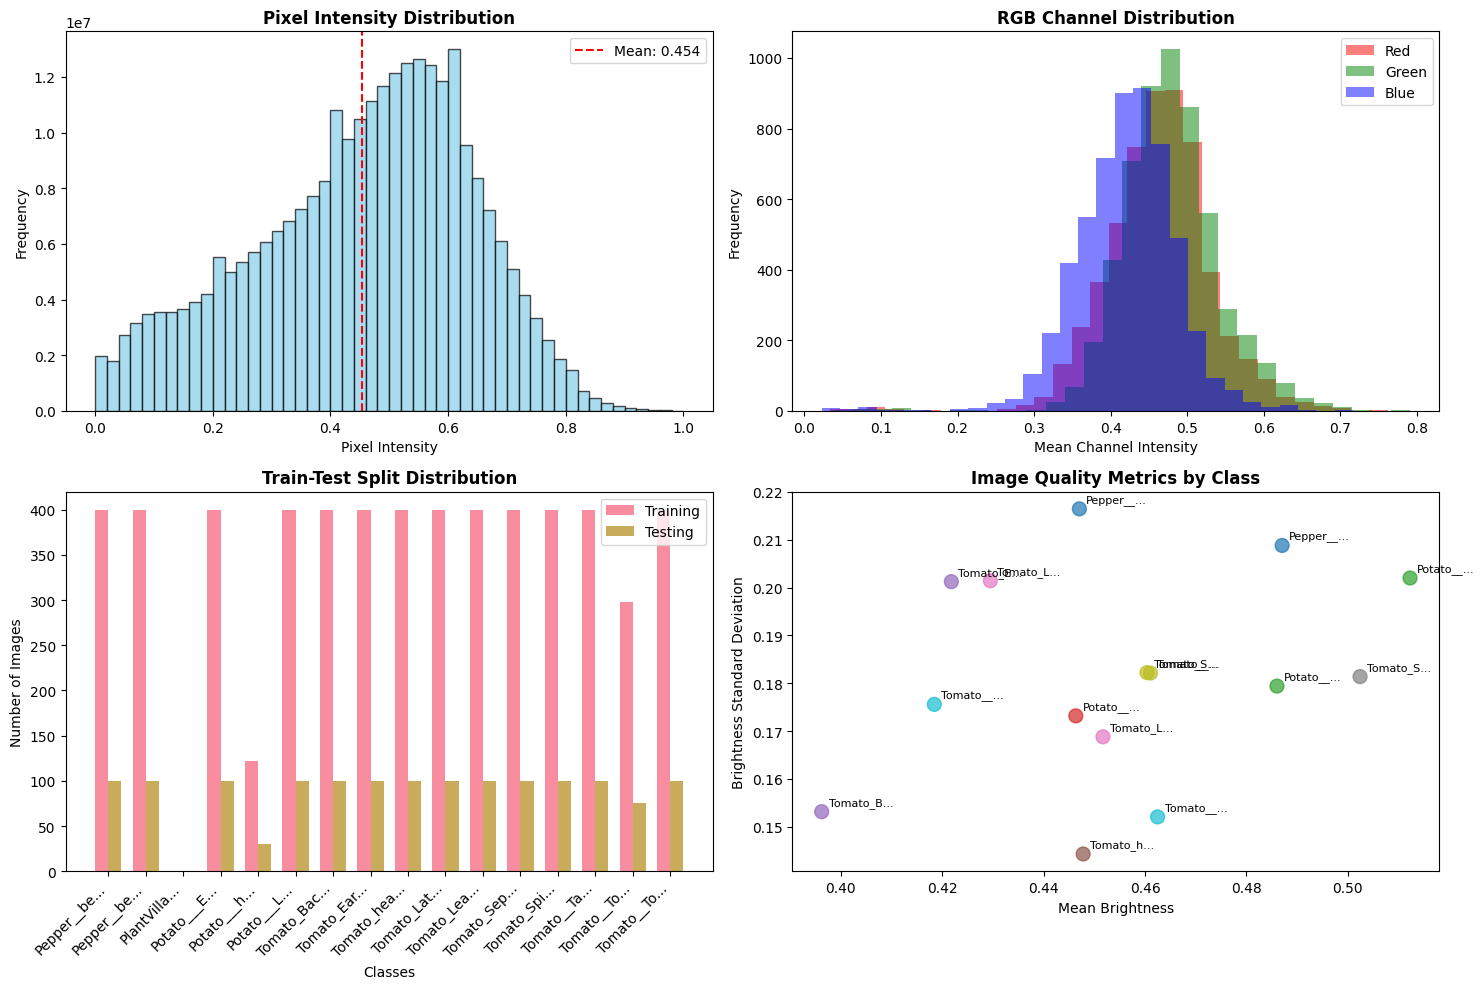


📊 SUMMARY STATISTICS
Dataset Shape: (7025, 128, 128, 3)
Pixel Value Range: [0.000, 1.000]
Pixel Value Range: [0.000, 1.000]
Mean Pixel Intensity: 0.454
Mean Pixel Intensity: 0.454
Std Pixel Intensity: 0.186
Total Parameters (if flattened): 49,152

Class Distribution Summary:
  Pepper__bell___Bacterial_spot: 500 images (7.1%)
  Pepper__bell___healthy: 500 images (7.1%)
  PlantVillage: 0 images (0.0%)
  Potato___Early_blight: 500 images (7.1%)
  Potato___healthy: 152 images (2.2%)
  Potato___Late_blight: 500 images (7.1%)
  Tomato_Bacterial_spot: 500 images (7.1%)
  Tomato_Early_blight: 500 images (7.1%)
  Tomato_healthy: 500 images (7.1%)
  Tomato_Late_blight: 500 images (7.1%)
  Tomato_Leaf_Mold: 500 images (7.1%)
  Tomato_Septoria_leaf_spot: 500 images (7.1%)
  Tomato_Spider_mites_Two_spotted_spider_mite: 500 images (7.1%)
  Tomato__Target_Spot: 500 images (7.1%)
  Tomato__Tomato_mosaic_virus: 373 images (5.3%)
  Tomato__Tomato_YellowLeaf__Curl_Virus: 500 images (7.1%)

✅ Data proces

In [5]:
# Enhanced Data Visualization and Analysis

print("📊 GENERATING VISUALIZATIONS")
print("=" * 40)

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# 1. Enhanced Class Distribution Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Count plot
class_names_short = [name.replace('_', '\n').replace('Tomato', 'T.').replace('Potato', 'P.').replace('Pepper', 'Pep.') 
                     for name in categories]
class_counts_list = [class_counts.get(cat, 0) for cat in categories]

bars = ax1.bar(range(len(categories)), class_counts_list, color=sns.color_palette("husl", len(categories)))
ax1.set_title("Class Distribution", fontsize=14, fontweight='bold')
ax1.set_xlabel("Disease Classes", fontsize=12)
ax1.set_ylabel("Number of Images", fontsize=12)
ax1.set_xticks(range(len(categories)))
ax1.set_xticklabels(class_names_short, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Pie chart for class distribution
ax2.pie(class_counts_list, labels=class_names_short, autopct='%1.1f%%', startangle=90)
ax2.set_title("Class Distribution (%)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 2. Sample Images Grid with Enhanced Layout
print("\n🖼️  Sample Images from Each Class:")
n_classes = len(categories)
cols = 4
rows = (n_classes + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3))
axes = axes.flatten() if rows > 1 else [axes] if rows == 1 else axes

for idx, category in enumerate(categories):
    # Find first image of this class
    class_indices = np.where(y_train == idx)[0]
    if len(class_indices) > 0:
        sample_img = X_train[class_indices[0]]
        axes[idx].imshow(sample_img)
        axes[idx].set_title(f"{category.replace('_', ' ')}", fontsize=10, fontweight='bold')
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, 'No samples', ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f"{category.replace('_', ' ')}", fontsize=10)
        axes[idx].axis('off')

# Hide extra subplots
for idx in range(len(categories), len(axes)):
    axes[idx].axis('off')

plt.suptitle("Sample Images from Each Disease Class", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 3. Multiple Random Samples
print("\n🎲 Random Sample Grid (3x3):")
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(9):
    row, col = i // 3, i % 3
    random_idx = np.random.randint(0, len(X_train))
    axes[row, col].imshow(X_train[random_idx])
    axes[row, col].set_title(f"{categories[y_train[random_idx]].replace('_', ' ')}", 
                            fontsize=10, fontweight='bold')
    axes[row, col].axis('off')

plt.suptitle("Random Sample Images", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Data Statistics Visualization
print("\n📈 Dataset Statistics:")

# Create a comprehensive statistics plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Pixel intensity distribution
pixel_intensities = X_train.flatten()
ax1.hist(pixel_intensities, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title("Pixel Intensity Distribution", fontweight='bold')
ax1.set_xlabel("Pixel Intensity")
ax1.set_ylabel("Frequency")
ax1.axvline(pixel_intensities.mean(), color='red', linestyle='--', 
            label=f'Mean: {pixel_intensities.mean():.3f}')
ax1.legend()

# RGB channel analysis
r_mean = X_train[:, :, :, 0].mean(axis=(1, 2))
g_mean = X_train[:, :, :, 1].mean(axis=(1, 2))
b_mean = X_train[:, :, :, 2].mean(axis=(1, 2))

ax2.hist(r_mean, alpha=0.5, label='Red', color='red', bins=30)
ax2.hist(g_mean, alpha=0.5, label='Green', color='green', bins=30)
ax2.hist(b_mean, alpha=0.5, label='Blue', color='blue', bins=30)
ax2.set_title("RGB Channel Distribution", fontweight='bold')
ax2.set_xlabel("Mean Channel Intensity")
ax2.set_ylabel("Frequency")
ax2.legend()

# Class balance visualization
train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)

x_pos = np.arange(len(categories))
width = 0.35

bars1 = ax3.bar(x_pos - width/2, train_counts, width, label='Training', alpha=0.8)
bars2 = ax3.bar(x_pos + width/2, test_counts, width, label='Testing', alpha=0.8)

ax3.set_title("Train-Test Split Distribution", fontweight='bold')
ax3.set_xlabel("Classes")
ax3.set_ylabel("Number of Images")
ax3.set_xticks(x_pos)
ax3.set_xticklabels([cat[:10] + '...' if len(cat) > 10 else cat for cat in categories], 
                    rotation=45, ha='right')
ax3.legend()

# Image size and quality metrics
mean_brightness = [X_train[y_train == i].mean() for i in range(len(categories))]
std_brightness = [X_train[y_train == i].std() for i in range(len(categories))]

ax4.scatter(mean_brightness, std_brightness, s=100, alpha=0.7, 
           c=range(len(categories)), cmap='tab10')
ax4.set_title("Image Quality Metrics by Class", fontweight='bold')
ax4.set_xlabel("Mean Brightness")
ax4.set_ylabel("Brightness Standard Deviation")

for i, cat in enumerate(categories):
    if i < len(mean_brightness):
        ax4.annotate(cat[:8] + '...' if len(cat) > 8 else cat, 
                    (mean_brightness[i], std_brightness[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n📊 SUMMARY STATISTICS")
print("=" * 40)
print(f"Dataset Shape: {X.shape}")
print(f"Pixel Value Range: [{X.min():.3f}, {X.max():.3f}]")
print(f"Mean Pixel Intensity: {X.mean():.3f}")
print(f"Std Pixel Intensity: {X.std():.3f}")
print(f"Total Parameters (if flattened): {X.shape[1] * X.shape[2] * X.shape[3]:,}")

print(f"\nClass Distribution Summary:")
for i, (cat, count) in enumerate(zip(categories, class_counts_list)):
    percentage = (count / sum(class_counts_list)) * 100
    print(f"  {cat}: {count} images ({percentage:.1f}%)")

print(f"\n✅ Data processing and analysis completed!")
print(f"💾 Dataset ready for model training phase (Week 2-3)")
print(f"🔗 Upload this notebook to your GitHub repository for Week 1 submission")
